In [16]:
%load_ext autoreload
%autoreload 2
%cd ~/Research/Sriram/DeepSetRNN

import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import os
import string
import pickle
from collections import namedtuple
from src import experiment_utils

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import logging
import os
import importlib

from src import convert_dot_format

DATA_PATH='data/MIMIC3database'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/minh/Research/Sriram/DeepSetRNN


In [17]:
logging.info("starting logger")
_LOGGER = logging.getLogger('MIMIC_seq_model')
_LOGGER.setLevel(logging.DEBUG)

# Preprocessing Data

In [3]:
top_n = 100 #should be the same as before
diagnoses_procedures_df = pd.read_csv('data/MIMIC3database/processed/ICD9_diagnoses_procedures_mimic_idx_sentences_top_100_sorted.csv', index_col=0)

#converting sentences to a single column
diagnoses_procedures_df['DIAGNOSES_SENTENCES'] = diagnoses_procedures_df[['0_diagnoses', '1_diagnoses',
       '2_diagnoses', '3_diagnoses', '4_diagnoses', '5_diagnoses',
       '6_diagnoses', '7_diagnoses', '8_diagnoses', '9_diagnoses',
       '10_diagnoses', '11_diagnoses', '12_diagnoses', '13_diagnoses',
       '14_diagnoses', '15_diagnoses', '16_diagnoses', '17_diagnoses',
       '18_diagnoses', '19_diagnoses', '20_diagnoses', '21_diagnoses', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31']].values.tolist()

diagnoses_procedures_df['PROCEDURES_SENTENCES'] = diagnoses_procedures_df[
    ['0_procedures', '1_procedures', '2_procedures', '3_procedures',
       '4_procedures', '5_procedures', '6_procedures', '7_procedures',
       '8_procedures', '9_procedures', '10_procedures', '11_procedures',
       '12_procedures', '13_procedures', '14_procedures', '15_procedures',
       '16_procedures', '17_procedures', '18_procedures', '19_procedures',
       '20_procedures', '21_procedures']].values.tolist()

diagnoses_procedures_df.drop(labels=['0_diagnoses', '1_diagnoses',
       '2_diagnoses', '3_diagnoses', '4_diagnoses', '5_diagnoses',
       '6_diagnoses', '7_diagnoses', '8_diagnoses', '9_diagnoses',
       '10_diagnoses', '11_diagnoses', '12_diagnoses', '13_diagnoses',
       '14_diagnoses', '15_diagnoses', '16_diagnoses', '17_diagnoses',
       '18_diagnoses', '19_diagnoses', '20_diagnoses', '21_diagnoses', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31'], axis=1, inplace=True)

diagnoses_procedures_df.drop(labels=['0_procedures', '1_procedures', '2_procedures', '3_procedures',
       '4_procedures', '5_procedures', '6_procedures', '7_procedures',
       '8_procedures', '9_procedures', '10_procedures', '11_procedures',
       '12_procedures', '13_procedures', '14_procedures', '15_procedures',
       '16_procedures', '17_procedures', '18_procedures', '19_procedures',
       '20_procedures', '21_procedures'], axis=1, inplace=True)

diagnoses_procedures_df.to_csv("data/MIMIC3database/processed/ICD9_diagnoses_procedures_mimic_idx_sentences_top_100_sorted_concat.csv")

In [4]:
diagnoses_counts = diagnoses_procedures_df['ICD9_CODE_diagnoses'].value_counts()
procedures_counts = diagnoses_procedures_df['ICD9_CODE_procedures'].value_counts()

diagnoses_set = set(diagnoses_counts.keys()[:top_n])
procedures_set = set(procedures_counts.keys()[:top_n])

diagnoses_idx_map = {}
for i, code in enumerate(diagnoses_counts.keys()[:top_n]):
    diagnoses_idx_map[code] = i

data = list(diagnoses_procedures_df.groupby(['SUBJECT_ID']))
data = [(subject_id, list(subject_data.groupby(['HADM_ID', 'ADMITTIME']))) for subject_id, subject_data in data]


def get_onehot_vector(indices, top_n):
    prediction = np.zeros(top_n, dtype='float32')
    prediction[indices] = 1
    return prediction

all_inputs = []
all_outputs = []
for _, subject in data:
    input_series = []
    output_series = []
    for _, timestep in subject:
        timestep = timestep[timestep['ICD9_CODE_diagnoses'].isin(diagnoses_set)
                           | timestep['ICD9_CODE_procedures'].isin(procedures_set)]
        indices = [diagnoses_idx_map[key] for key in timestep['ICD9_CODE_diagnoses'] if key in diagnoses_set]
        if len(timestep) > 0:
            input_series.append((np.stack(timestep['DIAGNOSES_SENTENCES'],axis=0), np.stack(timestep['PROCEDURES_SENTENCES'],axis=0)))
            output_series.append(get_onehot_vector(indices, top_n))
    if len(input_series) > 0 and len(output_series):
        all_inputs.append(input_series)
        all_outputs.append(np.array(output_series))


# all_outputs = []

# def get_onehot_vector(indices, top_n):
#     prediction = np.zeros(top_n, dtype='float32')
#     prediction[indices] = 1
#     return prediction

# for _, subject in data:
#     series = []
#     for _, timestep in subject:
#         indices = [diagnoses_idx_map[key] for key in timestep['ICD9_CODE_diagnoses'] \
#                   if key in diagnoses_set]
#         if len(timestep) > 0:
#             series.append(get_onehot_vector(indices, top_n))
#     if len(series) > 0:
#         all_outputs.append(np.array(series))

In [6]:
min_len = 3

inputs = list(filter(lambda x : len(x) >= min_len, all_inputs))
outputs = list(filter(lambda x: len(x) >= min_len, all_outputs))

n_seq = len(inputs)

split = int(n_seq*0.8)
train_inputs = inputs[:split]
train_outputs =  outputs[:split]

test_inputs = inputs[split:n_seq]
test_outputs = outputs[split:n_seq]

In [7]:
word_embedding = pd.read_csv('data/embeddings/w2vModel1Gram9Jan2019_mimic_only.txt', index_col=0)
word_embedding.drop('0',axis=1,inplace=True)
word_embedding = torch.tensor(word_embedding.astype('float32').values)

# Training Models

In [18]:
,#global objects
training_loss_map = {}
model_map = {}

In [19]:
_MODEL_LOG_ROOT_PATH = 'logs/MIMIC3/embedded'
_MODEL_ROOT_PATH = 'models/MIMIC3/embedded'

In [44]:
def run_train_and_log_experiments(model_name, model, loss_fn, optimizer):
    experiment_utils.setup_model_logger(_LOGGER, model_name, _MODEL_LOG_ROOT_PATH)
    _LOGGER.info(model_name)

    #initial test loss
    test_losses = experiment_utils.evaluate_validation_loss(model, loss_fn, test_inputs, test_outputs)
    _LOGGER.info("Initial Validation Loss: {}".format(np.mean(test_losses)))

    #training model
    training_losses = experiment_utils.train_model(model, loss_fn, optimizer,
                                                  args.n_epoch, train_inputs, 
                                                   train_outputs, _LOGGER)

    #saving model
    torch.save(model, '{}/{}.pt'.format(_MODEL_ROOT_PATH, model_name))

    #final validation loss
    test_losses = experiment_utils.evaluate_validation_loss(model, loss_fn, test_inputs, test_outputs)
    _LOGGER.info("final validation Loss: {}".format(np.mean(test_losses)))

    #saving model in global map
    model_map[model_name] = model
    training_loss_map[model_name] = training_losses


In [135]:
######LSTM MODEL#####
from src.model.mimic_deepset import EmbeddedSetLSTMClassifier

ModelArgs = namedtuple('EmbeddedLSTM', 
                      ['hidden_dim',
                       'n_epoch',
                       'lr',
                       'momentum',
                      'n_layers',
                      'dropout',
                      'freeze_embedding'])
args = ModelArgs(
    hidden_dim=[1000,100],
    n_epoch = 10,
    lr = 0.1,
    n_layers=1,
    momentum = 0.9,
    dropout=0.2,
    freeze_embedding=True
)

model_name = str(args)

model = EmbeddedSetLSTMClassifier(hidden_dim=args.hidden_dim, 
                                  n_class=top_n,
                                  embedding=word_embedding,
                                  freeze_embedding=args.freeze_embedding,
                                 dropout=args.dropout)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
run_train_and_log_experiments(model_name, model, loss_fn, optimizer)



/home/minh/.conda/envs/deepset/lib/python3.6/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
INFO:MIMIC_seq_model:EmbeddedLSTM(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9, n_layers=1, dropout=0.2, freeze_embedding=True)
INFO:MIMIC_seq_model:Initial Validation Loss: 0.6926378607749939
DEBUG:MIMIC_seq_model:training model
INFO:MIMIC_seq_model:epoch: 0, loss: 0.22006887197494507
INFO:MIMIC_seq_model:epoch: 1, loss: 0.18248900771141052
INFO:MIMIC_seq_model:epoch: 2, loss: 0.161867156624794
INFO:MIMIC_seq_model:epoch: 3, loss: 0.14848822355270386
INFO:MIMIC_seq_model:epoch: 4, loss: 0.13841883838176727
INFO:MIMIC_seq_model:epoch: 5, loss: 0.12948691844940186
INFO:MIMIC_seq_model:epoch: 6, loss: 0.1212199479341507
INFO:MIMIC_seq_model:epoch: 7, loss: 0.11403857171535492
IN

In [55]:
###FULLY CONNECTED MODEL#####
from src.model.mimic_deepset import FullyConnectedNetworkClassifier

ModelArgs = namedtuple('EmbeddedFCN', 
                      ['hidden_dim',
                       'n_epoch',
                       'lr',
                       'momentum',
                      'freeze_embedding'])
args = ModelArgs(
    hidden_dim=[1000,100],
    n_epoch = 10,
    lr = 0.1,
    momentum = 0.9,
    freeze_embedding=True
)

model_name = str(args)

model = FullyConnectedNetworkClassifier(hidden_dims=args.hidden_dim, 
                                  n_class=top_n,
                                  embedding=word_embedding,
                                  freeze_embedding=args.freeze_embedding)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)


run_train_and_log_experiments(model_name, model, loss_fn, optimizer)

INFO:MIMIC_seq_model:EmbeddedFCN(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9, freeze_embedding=True)
INFO:MIMIC_seq_model:Initial Validation Loss: 0.6980988383293152
DEBUG:MIMIC_seq_model:training model
INFO:MIMIC_seq_model:epoch: 0, loss: 0.21474993228912354
INFO:MIMIC_seq_model:epoch: 1, loss: 0.16153521835803986
INFO:MIMIC_seq_model:epoch: 2, loss: 0.14259444177150726
INFO:MIMIC_seq_model:epoch: 3, loss: 0.12826266884803772
INFO:MIMIC_seq_model:epoch: 4, loss: 0.1158418208360672
INFO:MIMIC_seq_model:epoch: 5, loss: 0.10824453830718994
INFO:MIMIC_seq_model:epoch: 6, loss: 0.10117420554161072
INFO:MIMIC_seq_model:epoch: 7, loss: 0.09594278037548065
INFO:MIMIC_seq_model:epoch: 8, loss: 0.09080421179533005
INFO:MIMIC_seq_model:epoch: 9, loss: 0.08763530850410461
INFO:MIMIC_seq_model:final validation Loss: 0.412952184677124


In [54]:
####LOG REG CLASSIFIER#####
from src.model.mimic_deepset import EmbeddedLogRegClassifier

ModelArgs = namedtuple('EmbeddedLogReg', 
                      ['n_epoch',
                       'lr',
                       'momentum',
                      'freeze_embedding'])
args = ModelArgs(
    n_epoch = 10,
    lr = 0.1,
    momentum = 0.9,
    freeze_embedding=True
)

model_name = str(args)

model = EmbeddedLogRegClassifier(n_class=top_n,
                                  embedding=word_embedding,
                                  freeze_embedding=args.freeze_embedding)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)


run_train_and_log_experiments(model_name, model, loss_fn, optimizer)

INFO:MIMIC_seq_model:EmbeddedLogReg(n_epoch=10, lr=0.1, momentum=0.9, freeze_embedding=True)
INFO:MIMIC_seq_model:Initial Validation Loss: 0.7478676438331604
DEBUG:MIMIC_seq_model:training model
INFO:MIMIC_seq_model:epoch: 0, loss: 0.3238961398601532
INFO:MIMIC_seq_model:epoch: 1, loss: 0.23327021300792694
INFO:MIMIC_seq_model:epoch: 2, loss: 0.1901165395975113
INFO:MIMIC_seq_model:epoch: 3, loss: 0.17020587623119354
INFO:MIMIC_seq_model:epoch: 4, loss: 0.15518753230571747
INFO:MIMIC_seq_model:epoch: 5, loss: 0.13837558031082153
INFO:MIMIC_seq_model:epoch: 6, loss: 0.12967632710933685
INFO:MIMIC_seq_model:epoch: 7, loss: 0.12212254106998444
INFO:MIMIC_seq_model:epoch: 8, loss: 0.11140616238117218
INFO:MIMIC_seq_model:epoch: 9, loss: 0.10666217654943466
INFO:MIMIC_seq_model:final validation Loss: 0.5996338129043579


# Analysis

In [136]:
analysis_log_path = "{}/{}.log".format(_MODEL_LOG_ROOT_PATH, "analysis")
if os.path.exists(analysis_log_path):
    os.remove(analysis_log_path)

_LOGGER.handlers = [
    h for h in _LOGGER.handlers if not isinstance(h, logging.StreamHandler)]
fh = logging.FileHandler('logs/MIMIC3/embedded_models_analysis.log')
fh.setLevel(logging.DEBUG)
_LOGGER.addHandler(fh)

In [137]:
test_prediction_map = {}
test_logits_map = {}
test_output_map = {}
#preprocessing test outputs
sigmoid = nn.Sigmoid()
for model_name, model in model_map.items():
    all_logits = []
    all_outputs = []
    all_predictions = []
    for sequence, target in zip(test_inputs, test_outputs):    
        logits = model(sequence)

        model_outputs = sigmoid(logits).detach().numpy()
        predictions = model_outputs > 0.5
        predictions = predictions.astype(np.float32)

        all_outputs.append(model_outputs)
        all_logits.append(logits.detach().numpy())
        all_predictions.append(predictions)
    test_prediction_map[model_name] = all_predictions
    test_logits_map[model_name] = all_logits
    test_output_map[model_name] = all_outputs

In [138]:
#precision@k
from src.utils import precision_at_k, bootstrap_CI
k_values = [1,2,3]
for k in k_values:
    _LOGGER.info("K")
    for model_name in model_map:
            pk = precision_at_k(test_logits_map[model_name], test_outputs, k)
            _LOGGER.info("{} {}".format(model_name, pk))

INFO:MIMIC_seq_model:K
INFO:MIMIC_seq_model:EmbeddedLSTM(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9, n_layers=1, dropout=0, freeze_embedding=True) 0.5699100572363042
INFO:MIMIC_seq_model:EmbeddedFCN(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9, freeze_embedding=True) 0.5470155355682748
INFO:MIMIC_seq_model:EmbeddedLogReg(n_epoch=10, lr=0.1, momentum=0.9, freeze_embedding=True) 0.570727718724448
INFO:MIMIC_seq_model:EmbeddedLSTM(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9, n_layers=1, dropout=0.5, freeze_embedding=True) 0.6271463614063778
INFO:MIMIC_seq_model:EmbeddedLSTM(hidden_dim=[1000, 100], n_epoch=20, lr=0.1, momentum=0.9, n_layers=1, dropout=0.5, freeze_embedding=True) 0.634505314799673
INFO:MIMIC_seq_model:EmbeddedLSTM(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9, n_layers=1, dropout=0.2, freeze_embedding=True) 0.5658217497955846
INFO:MIMIC_seq_model:K
INFO:MIMIC_seq_model:EmbeddedLSTM(hidden_dim=[1000, 100], n_epoch=10, lr=0.1,

In [139]:
#precision@k with confidence intervals
from src.utils import precision_at_k, bootstrap_CI
from sklearn.utils import resample

k_values = [1,2,3]
n_bootstrap = 1000

bootstrap_pk_map = {}
pk_CI_map = {}

for k in k_values:
    _LOGGER.info("Computing Precision@{}".format(k))
    for model_name in model_map:
        pk, CI = bootstrap_CI(precision_at_k, {'k':k}, 
                             (test_logits_map[model_name], test_outputs),
                              n_bootstrap)
        bootstrap_pk_map[model_name] = pk
        pk_CI_map[model_name] = CI
        _LOGGER.info("{} {}".format(model_name, CI))

INFO:MIMIC_seq_model:Computing Precision@1
INFO:MIMIC_seq_model:EmbeddedLSTM(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9, n_layers=1, dropout=0, freeze_embedding=True) (0.5684667979550694, 0.5704472279043583)
INFO:MIMIC_seq_model:EmbeddedFCN(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9, freeze_embedding=True) (0.5467025581116399, 0.5488181401134212)
INFO:MIMIC_seq_model:EmbeddedLogReg(n_epoch=10, lr=0.1, momentum=0.9, freeze_embedding=True) (0.5697770702943202, 0.571726236117038)
INFO:MIMIC_seq_model:EmbeddedLSTM(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9, n_layers=1, dropout=0.5, freeze_embedding=True) (0.6265878046380104, 0.6286274453154701)
INFO:MIMIC_seq_model:EmbeddedLSTM(hidden_dim=[1000, 100], n_epoch=20, lr=0.1, momentum=0.9, n_layers=1, dropout=0.5, freeze_embedding=True) (0.6329105158449759, 0.6349026620952061)
INFO:MIMIC_seq_model:EmbeddedLSTM(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9, n_layers=1, dropout=0.2, freeze_embe

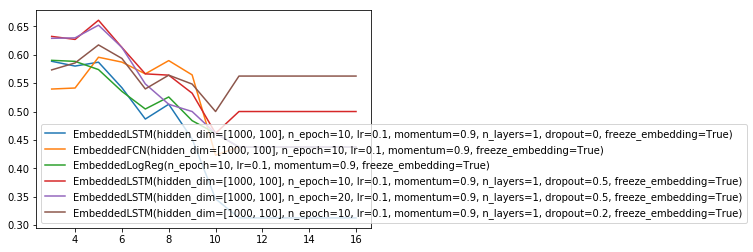

In [140]:
k = 1
pk_vs_len_map = {}

max_len = max(map(len, test_outputs))
for model_name in model_map:
    pks = []
    filtered_logits = test_logits_map[model_name]
    filtered_test_outputs = test_outputs
    
    for filter_len in range(min_len, max_len):
        indices = [i for (i,sequence) in enumerate(filtered_test_outputs) if len(sequence) > filter_len]
        
        filtered_logits = [filtered_logits[i] for i in indices]
        filtered_test_outputs = [filtered_test_outputs[i] for i in indices]
        #print(len(filtered_test_outputs))
        pks.append(precision_at_k(filtered_logits, filtered_test_outputs, k))
    pk_vs_len_map[model_name] = pks
    
max_len = max(map(len, test_outputs))

for model_name, pks in pk_vs_len_map.items():
    plt.plot(np.arange(3,max_len), pks, label=model_name)
plt.legend()

In [78]:
true_labels_flattened = np.concatenate(list((map(lambda x : x[1:].flatten(), test_outputs))))
for model_name in model_map:
    predictions = test_prediction_map[model_name]
    predictions_flattened = np.concatenate(list(map(lambda x : x[:-1].flatten(), predictions)))
    _LOGGER.info("{}\n{}".format(model_name,metrics.confusion_matrix(true_labels_flattened, predictions_flattened)))
    

INFO:MIMIC_seq_model:EmbeddedLSTM(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9, n_layers=1, dropout=0, freeze_embedding=True)
[[108704   3805]
 [  6502   3289]]
INFO:MIMIC_seq_model:EmbeddedFCN(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9, freeze_embedding=True)
[[108602   3907]
 [  6740   3051]]
INFO:MIMIC_seq_model:EmbeddedLogReg(n_epoch=10, lr=0.1, momentum=0.9, freeze_embedding=True)
[[108020   4489]
 [  6176   3615]]
INFO:MIMIC_seq_model:EmbeddedLSTM(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9, n_layers=1, dropout=0.5, freeze_embedding=True)
[[110799   1710]
 [  7624   2167]]
INFO:MIMIC_seq_model:EmbeddedLSTM(hidden_dim=[1000, 100], n_epoch=20, lr=0.1, momentum=0.9, n_layers=1, dropout=0.5, freeze_embedding=True)
[[110392   2117]
 [  7198   2593]]


/home/minh/.conda/envs/deepset/lib/python3.6/site-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "center bottom". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

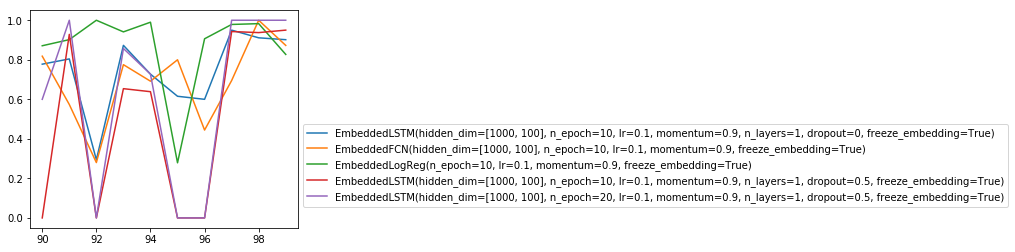

In [128]:
K_disease_map = defaultdict(list)

for disease_in_consideration in range(90, top_n):
    true_labels_for_disease = np.concatenate(list(map(lambda x : x[:,-disease_in_consideration:], test_outputs))).flatten()
    for model_name in model_map:
        prediction_at_k = np.concatenate(list(map(lambda x : x[:, -, disease_in_consideration], test_prediction_map[model_name]))).flatten()
        pk = metrics.precision_score(true_labels_for_disease, prediction_at_k)
        K_disease_map[model_name].append(pk)

        fig = plt.figure()
ax = plt.subplot(111)
for model_name, k_disease in K_disease_map.items():
    ax.plot(np.arange(90, top_n), k_disease ,label=model_name)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))plt.show()


In [ ]:
fig = plt.figure()
ax = plt.subplot(111)

for i in xrange(5):
    ax.plot(x, i * x, label='$y = %ix$' % i)

ax.legend()

plt.show()